In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go

# NLP Libraries
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VaderAnalyzer
import spacy
from wordcloud import WordCloud

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

print("NLP Environment Setup Complete")
print("All sentiment analysis libraries loaded successfully")

NLP Environment Setup Complete
All sentiment analysis libraries loaded successfully


In [3]:
# Load the sentiment dataset
# Note: This dataset has no header, so we need to specify column names
column_names = ['target', 'id', 'date', 'flag', 'user', 'text']

# Load dataset (sample first to avoid memory issues)
df = pd.read_csv('data/sentiment140.csv', encoding='latin1', names=column_names)

print("Dataset Basic Information:")
print(f"Dataset Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
df.info()

print("\nMissing Values:")
print(df.isnull().sum())

print("\nBasic Statistics:")
print(df.describe(include='all'))

Dataset Basic Information:
Dataset Shape: (1600000, 6)
Columns: ['target', 'id', 'date', 'flag', 'user', 'text']
Memory Usage: 556.15 MB

First 5 rows:
   target          id                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  

Dataset Info:
<class 'pa

In [4]:
# Sentiment Analysis
print("=== Sentiment Distribution Analysis ===")
print(f"Unique sentiment values: {df['target'].unique()}")
print(f"Sentiment distribution:\n{df['target'].value_counts()}")

# Map sentiment values (0 = negative, 4 = positive in this dataset)
sentiment_mapping = {0: 'Negative', 4: 'Positive'}
df['sentiment_label'] = df['target'].map(sentiment_mapping)

print(f"\nSentiment Label Distribution:")
print(df['sentiment_label'].value_counts())
print(f"Sentiment Balance: {df['sentiment_label'].value_counts(normalize=True) * 100}")

# Text Analysis
print(f"\n=== Text Analysis ===")
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

print(f"Average text length: {df['text_length'].mean():.2f} characters")
print(f"Average word count: {df['word_count'].mean():.2f} words")
print(f"Max text length: {df['text_length'].max()} characters")
print(f"Min text length: {df['text_length'].min()} characters")

# Sample tweets by sentiment
print(f"\n=== Sample Tweets ===")
print("Positive Tweets:")
positive_samples = df[df['sentiment_label'] == 'Positive']['text'].sample(3)
for i, tweet in enumerate(positive_samples, 1):
    print(f"{i}. {tweet}")

print("\nNegative Tweets:")
negative_samples = df[df['sentiment_label'] == 'Negative']['text'].sample(3)
for i, tweet in enumerate(negative_samples, 1):
    print(f"{i}. {tweet}")

=== Sentiment Distribution Analysis ===
Unique sentiment values: [0 4]
Sentiment distribution:
target
0    800000
4    800000
Name: count, dtype: int64

Sentiment Label Distribution:
sentiment_label
Negative    800000
Positive    800000
Name: count, dtype: int64
Sentiment Balance: sentiment_label
Negative    50.0
Positive    50.0
Name: proportion, dtype: float64

=== Text Analysis ===
Average text length: 74.10 characters
Average word count: 13.18 words
Max text length: 803 characters
Min text length: 6 characters

=== Sample Tweets ===
Positive Tweets:
1. hope to finish one project and start Run #3 today 
2. @chipstreet and @garysanders1 But no zombies 
3. @StuartGarrard They do seem intent on annoying PETA http://bit.ly/SzPvu  

Negative Tweets:
1. @niksargent and @steveellwood My TV is HD capable but have no sources   Looking to gain benefit from it.  Cheaper is  http://bit.ly/1vdlJ
2. whoa! nadal is out at the french! 
3. @Tqualls04 Aww ...i'm  sorry love 


In [5]:
# User Analysis
print(f"\n=== User Analysis ===")
print(f"Unique users: {df['user'].nunique():,}")
print(f"Total tweets: {len(df):,}")
print(f"Average tweets per user: {len(df) / df['user'].nunique():.2f}")

# Top users by tweet count
top_users = df['user'].value_counts().head(10)
print(f"\nTop 10 Most Active Users:")
print(top_users)

# Date Analysis
print(f"\n=== Temporal Analysis ===")
try:
    # Convert date string to datetime (format may vary)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    if df['date'].notna().sum() > 0:
        date_range = f"{df['date'].min()} to {df['date'].max()}"
        print(f"Date range: {date_range}")
        
        # Daily tweet counts
        daily_tweets = df.groupby(df['date'].dt.date)['id'].count()
        print(f"Average daily tweets: {daily_tweets.mean():.0f}")
        print(f"Peak day: {daily_tweets.idxmax()} with {daily_tweets.max():,} tweets")
    else:
        print("Date parsing failed - will use text analysis only")
except Exception as e:
    print(f"Date analysis skipped: {str(e)}")

# Text preprocessing preview
print(f"\n=== Text Preprocessing Preview ===")

# Sample preprocessing
import re

def basic_preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Apply to a sample
sample_tweets = df['text'].head(5)
print("Before preprocessing:")
for i, tweet in enumerate(sample_tweets, 1):
    print(f"{i}. {tweet}")

print("\nAfter preprocessing:")
for i, tweet in enumerate(sample_tweets, 1):
    processed = basic_preprocess(tweet)
    print(f"{i}. {processed}")

# Memory optimization - sample dataset if too large
if len(df) > 100000:
    print(f"\n=== Dataset Sampling ===")
    df_sample = df.sample(n=100000, random_state=42)
    print(f"Sampled {len(df_sample):,} tweets from {len(df):,} total")
    
    # Maintain sentiment balance
    positive_sample = df[df['sentiment_label'] == 'Positive'].sample(n=50000, random_state=42)
    negative_sample = df[df['sentiment_label'] == 'Negative'].sample(n=50000, random_state=42)
    df_balanced = pd.concat([positive_sample, negative_sample]).sample(frac=1, random_state=42)
    
    print(f"Balanced sample created: {len(df_balanced):,} tweets")
    print(f"Sentiment distribution:\n{df_balanced['sentiment_label'].value_counts()}")
    
    # Use balanced sample for analysis
    df_working = df_balanced.copy()
else:
    df_working = df.copy()

print(f"\nWorking dataset: {df_working.shape}")
print("Data exploration complete!")


=== User Analysis ===
Unique users: 659,775
Total tweets: 1,600,000
Average tweets per user: 2.43

Top 10 Most Active Users:
user
lost_dog           549
webwoke            345
tweetpet           310
SallytheShizzle    281
VioletsCRUK        279
mcraddictal        276
tsarnick           248
what_bugs_u        246
Karen230683        238
DarkPiano          236
Name: count, dtype: int64

=== Temporal Analysis ===
Date range: 2009-04-06 22:19:45 to 2009-06-25 10:28:31
Average daily tweets: 33333
Peak day: 2009-06-06 with 111,676 tweets

=== Text Preprocessing Preview ===
Before preprocessing:
1. @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
2. is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
3. @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
4. my whole body feels itchy and like its on fire 
5. @nationwideclass no, it

In [6]:
# Create comprehensive text preprocessing pipeline
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string

# Download additional NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

print("=== Advanced Text Preprocessing ===")

# Initialize preprocessing tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def advanced_preprocess(text):
    """Comprehensive text preprocessing for sentiment analysis"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML entities
    text = re.sub(r'&amp;|&lt;|&gt;', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions and hashtags (but keep the content)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)  # Keep hashtag content
    
    # Remove extra punctuation but keep emoticons
    # First preserve common emoticons
    emoticons = re.findall(r'[:\-=][)\(DPp\[\]|\\/@#$%^&*]|[)\(DPp\[\]|\\/@#$%^&*][\-=:][)\(DPp\[\]|\\/@#$%^&*]?', text)
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
    
    # Add emoticons back
    text = text + ' ' + ' '.join(emoticons)
    
    # Remove digits (optional - may contain sentiment info)
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

def advanced_tokenize(text):
    """Advanced tokenization with stemming and lemmatization"""
    tokens = word_tokenize(text)
    
    # Remove stopwords and short words
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    
    # Apply lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

# Apply preprocessing
print("Applying advanced preprocessing...")
df_working['text_clean'] = df_working['text'].apply(advanced_preprocess)
df_working['tokens'] = df_working['text_clean'].apply(advanced_tokenize)
df_working['processed_text'] = df_working['tokens'].apply(lambda x: ' '.join(x))

# Calculate preprocessing statistics
df_working['clean_text_length'] = df_working['text_clean'].str.len()
df_working['clean_word_count'] = df_working['processed_text'].str.split().str.len()

print(f"Preprocessing complete!")
print(f"Average text length after cleaning: {df_working['clean_text_length'].mean():.2f} characters")
print(f"Average word count after processing: {df_working['clean_word_count'].mean():.2f} words")

# Show preprocessing examples
print(f"\nPreprocessing Examples:")
for i in range(3):
    original = df_working['text'].iloc[i]
    cleaned = df_working['text_clean'].iloc[i]
    processed = df_working['processed_text'].iloc[i]
    sentiment = df_working['sentiment_label'].iloc[i]
    
    print(f"\n--- Example {i+1} ({sentiment}) ---")
    print(f"Original: {original}")
    print(f"Cleaned:  {cleaned}")
    print(f"Processed: {processed}")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sandra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Sandra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sandra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sandra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Sandra\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


=== Advanced Text Preprocessing ===
Applying advanced preprocessing...
Preprocessing complete!
Average text length after cleaning: 62.35 characters
Average word count after processing: 6.57 words

Preprocessing Examples:

--- Example 1 (Negative) ---
Original: says sad to say pero makakabukas lng me ng pc tuwing weekends at pag may assign  http://plurk.com/p/xw32n
Cleaned:  says sad to say pero makakabukas lng me ng pc tuwing weekends at pag may assign
Processed: say sad say pero makakabukas lng tuwing weekend pag may assign

--- Example 2 (Negative) ---
Original: Allergies suck ducks nuts.     &lt;=====8@8=====&gt;
Cleaned:  allergies suck ducks nuts
Processed: allergy suck duck nut

--- Example 3 (Positive) ---
Original: @jordanknight U 5 guys could be standing in the north pole and it would Still be HOT HOT HOT!!!   xxxx
Cleaned:  u guys could be standing in the north pole and it would still be hot hot hot xxxx
Processed: guy could standing north pole would still hot hot hot xxxx


In [7]:
print("\n=== Multi-Model Sentiment Analysis ===")

# 1. VADER Sentiment Analysis
vader_analyzer = VaderAnalyzer()

def get_vader_sentiment(text):
    scores = vader_analyzer.polarity_scores(text)
    return scores['compound'], scores['pos'], scores['neu'], scores['neg']

# Apply VADER
print("Applying VADER sentiment analysis...")
vader_results = df_working['text_clean'].apply(get_vader_sentiment)
df_working['vader_compound'] = [result[0] for result in vader_results]
df_working['vader_positive'] = [result[1] for result in vader_results]
df_working['vader_neutral'] = [result[2] for result in vader_results]
df_working['vader_negative'] = [result[3] for result in vader_results]

# VADER sentiment classification
def classify_vader_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df_working['vader_sentiment'] = df_working['vader_compound'].apply(classify_vader_sentiment)

# 2. TextBlob Sentiment Analysis
print("Applying TextBlob sentiment analysis...")

def get_textblob_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

textblob_results = df_working['text_clean'].apply(get_textblob_sentiment)
df_working['textblob_polarity'] = [result[0] for result in textblob_results]
df_working['textblob_subjectivity'] = [result[1] for result in textblob_results]

def classify_textblob_sentiment(polarity):
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df_working['textblob_sentiment'] = df_working['textblob_polarity'].apply(classify_textblob_sentiment)

# 3. Custom lexicon-based approach
print("Creating custom sentiment features...")

# Load common sentiment words
positive_words = ['good', 'great', 'excellent', 'amazing', 'awesome', 'love', 'like', 
                  'happy', 'joy', 'wonderful', 'fantastic', 'perfect', 'best', 'beautiful']
negative_words = ['bad', 'terrible', 'awful', 'hate', 'dislike', 'sad', 'angry', 
                  'worst', 'horrible', 'disgusting', 'disappointed', 'frustrated', 'annoyed']

def count_sentiment_words(tokens):
    pos_count = sum(1 for token in tokens if token in positive_words)
    neg_count = sum(1 for token in tokens if token in negative_words)
    return pos_count, neg_count

sentiment_counts = df_working['tokens'].apply(count_sentiment_words)
df_working['positive_word_count'] = [result[0] for result in sentiment_counts]
df_working['negative_word_count'] = [result[1] for result in sentiment_counts]
df_working['sentiment_ratio'] = (df_working['positive_word_count'] - df_working['negative_word_count']) / (df_working['clean_word_count'] + 1)

print("Sentiment analysis complete!")


=== Multi-Model Sentiment Analysis ===
Applying VADER sentiment analysis...
Applying TextBlob sentiment analysis...
Creating custom sentiment features...
Sentiment analysis complete!


In [8]:
print("\n=== Feature Engineering ===")

# Text-based features
df_working['exclamation_count'] = df_working['text'].str.count('!')
df_working['question_count'] = df_working['text'].str.count('\?')
df_working['caps_ratio'] = df_working['text'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
df_working['mention_count'] = df_working['text'].str.count('@')
df_working['hashtag_count'] = df_working['text'].str.count('#')
df_working['url_count'] = df_working['text'].str.count('http')

# Readability features
df_working['avg_word_length'] = df_working['processed_text'].apply(
    lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0
)

# Emotional intensity features
df_working['emotional_intensity'] = abs(df_working['vader_compound'])
df_working['subjectivity_category'] = pd.cut(df_working['textblob_subjectivity'], 
                                            bins=[0, 0.3, 0.7, 1.0], 
                                            labels=['Objective', 'Moderate', 'Subjective'])

print("Feature engineering complete!")
print(f"Total features created: {df_working.shape[1]}")

# Display feature summary
feature_summary = df_working[['text_length', 'clean_word_count', 'vader_compound', 
                             'textblob_polarity', 'positive_word_count', 'negative_word_count',
                             'exclamation_count', 'caps_ratio', 'emotional_intensity']].describe()

print(f"\nFeature Summary:")
print(feature_summary)

# Save preprocessed data
df_working.to_csv('data/preprocessed_tweets.csv', index=False)
print(f"\nPreprocessed data saved to: data/preprocessed_tweets.csv")


=== Feature Engineering ===
Feature engineering complete!
Total features created: 34

Feature Summary:
         text_length  clean_word_count  vader_compound  textblob_polarity  \
count  100000.000000     100000.000000   100000.000000      100000.000000   
mean       74.096430          6.566080        0.148399           0.094890   
std        36.537744          3.648549        0.446995           0.331327   
min         7.000000          0.000000       -0.993100          -1.000000   
25%        44.000000          4.000000       -0.077200           0.000000   
50%        69.000000          6.000000        0.000000           0.000000   
75%       104.000000          9.000000        0.510600           0.285714   
max       345.000000         23.000000        0.985400           1.000000   

       positive_word_count  negative_word_count  exclamation_count  \
count        100000.000000        100000.000000      100000.000000   
mean              0.230770             0.059180           0.57

In [9]:
print("\n=== Sentiment Model Comparison ===")

# Compare different sentiment analysis approaches
from sklearn.metrics import accuracy_score, classification_report

# Map original labels to consistent format
df_working['true_sentiment'] = df_working['sentiment_label']

# Filter out neutral predictions for binary comparison
binary_data = df_working[
    (df_working['vader_sentiment'].isin(['Positive', 'Negative'])) &
    (df_working['textblob_sentiment'].isin(['Positive', 'Negative']))
].copy()

print(f"Comparing models on {len(binary_data):,} tweets with clear sentiment predictions")

# VADER Performance
vader_accuracy = accuracy_score(binary_data['true_sentiment'], binary_data['vader_sentiment'])
print(f"\nVADER Sentiment Accuracy: {vader_accuracy:.4f}")
print("VADER Classification Report:")
print(classification_report(binary_data['true_sentiment'], binary_data['vader_sentiment']))

# TextBlob Performance
textblob_accuracy = accuracy_score(binary_data['true_sentiment'], binary_data['textblob_sentiment'])
print(f"\nTextBlob Sentiment Accuracy: {textblob_accuracy:.4f}")
print("TextBlob Classification Report:")
print(classification_report(binary_data['true_sentiment'], binary_data['textblob_sentiment']))

# Model performance summary
model_comparison = pd.DataFrame({
    'Model': ['VADER', 'TextBlob'],
    'Accuracy': [vader_accuracy, textblob_accuracy],
    'Dataset_Size': [len(binary_data), len(binary_data)]
})

print(f"\nModel Comparison Summary:")
print(model_comparison)

model_comparison.to_csv('output/sentiment_model_comparison.csv', index=False)

print(f"\nNLP preprocessing and sentiment analysis complete!")
print(f"Dataset ready for visualization and dashboard creation")


=== Sentiment Model Comparison ===
Comparing models on 49,923 tweets with clear sentiment predictions

VADER Sentiment Accuracy: 0.7365
VADER Classification Report:


              precision    recall  f1-score   support

    Negative       0.82      0.55      0.66     23188
    Positive       0.70      0.90      0.79     26735

    accuracy                           0.74     49923
   macro avg       0.76      0.72      0.72     49923
weighted avg       0.76      0.74      0.73     49923


TextBlob Sentiment Accuracy: 0.7217
TextBlob Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.52      0.63     23188
    Positive       0.68      0.90      0.78     26735

    accuracy                           0.72     49923
   macro avg       0.75      0.71      0.70     49923
weighted avg       0.74      0.72      0.71     49923


Model Comparison Summary:
      Model  Accuracy  Dataset_Size
0     VADER  0.736454         49923
1  TextBlob  0.721731         49923

NLP preprocessing and sentiment analysis complete!
Dataset ready for visualization and dashboard creation


In [10]:
# Load preprocessed data if needed
# df_working = pd.read_csv('data/preprocessed_tweets.csv')

print("=== Comprehensive Sentiment Analysis ===")

# Overall sentiment distribution
print("True Sentiment Distribution:")
true_sentiment_dist = df_working['true_sentiment'].value_counts()
print(true_sentiment_dist)
print(f"Percentage: {df_working['true_sentiment'].value_counts(normalize=True) * 100}")

# VADER vs True sentiment cross-tabulation
vader_confusion = pd.crosstab(df_working['true_sentiment'], df_working['vader_sentiment'], normalize='index')
print(f"\nVADER Prediction Accuracy by True Sentiment:")
print(vader_confusion.round(3))

# Sentiment intensity analysis
print(f"\n=== Sentiment Intensity Analysis ===")
sentiment_intensity = df_working.groupby('true_sentiment').agg({
    'vader_compound': ['mean', 'std', 'min', 'max'],
    'textblob_polarity': ['mean', 'std', 'min', 'max'],
    'emotional_intensity': ['mean', 'std']
}).round(3)

print("Sentiment Intensity by True Label:")
print(sentiment_intensity)

# Text characteristics by sentiment
print(f"\n=== Text Characteristics by Sentiment ===")
text_characteristics = df_working.groupby('true_sentiment').agg({
    'text_length': 'mean',
    'clean_word_count': 'mean',
    'exclamation_count': 'mean',
    'question_count': 'mean',
    'caps_ratio': 'mean',
    'positive_word_count': 'mean',
    'negative_word_count': 'mean',
    'mention_count': 'mean',
    'hashtag_count': 'mean'
}).round(3)

print("Text Characteristics:")
print(text_characteristics)

=== Comprehensive Sentiment Analysis ===
True Sentiment Distribution:
true_sentiment
Negative    50000
Positive    50000
Name: count, dtype: int64
Percentage: true_sentiment
Negative    50.0
Positive    50.0
Name: proportion, dtype: float64

VADER Prediction Accuracy by True Sentiment:
vader_sentiment  Negative  Neutral  Positive
true_sentiment                              
Negative            0.415    0.251     0.333
Positive            0.098    0.268     0.634

=== Sentiment Intensity Analysis ===
Sentiment Intensity by True Label:
               vader_compound                      textblob_polarity         \
                         mean    std    min    max              mean    std   
true_sentiment                                                                
Negative               -0.032  0.432 -0.993  0.976            -0.013  0.319   
Positive                0.329  0.384 -0.969  0.985             0.203  0.307   

                         emotional_intensity         
          

In [11]:
print(f"\n=== User Behavior and Engagement Analysis ===")

# Most active users analysis
user_activity = df_working.groupby('user').agg({
    'text': 'count',
    'vader_compound': 'mean',
    'textblob_polarity': 'mean',
    'emotional_intensity': 'mean',
    'true_sentiment': lambda x: (x == 'Positive').mean()
}).rename(columns={
    'text': 'tweet_count',
    'vader_compound': 'avg_vader_score',
    'textblob_polarity': 'avg_textblob_score',
    'emotional_intensity': 'avg_emotional_intensity',
    'true_sentiment': 'positive_ratio'
})

# Filter users with multiple tweets
active_users = user_activity[user_activity['tweet_count'] >= 3].copy()
active_users = active_users.sort_values('tweet_count', ascending=False)

print(f"Top 10 Most Active Users:")
print(active_users.head(10))

# Sentiment patterns by user activity level
df_working['user_activity_level'] = df_working['user'].map(user_activity['tweet_count'])
df_working['activity_category'] = pd.cut(df_working['user_activity_level'], 
                                        bins=[0, 1, 3, 10, float('inf')], 
                                        labels=['Single Tweet', 'Low Activity', 'Moderate Activity', 'High Activity'])

activity_sentiment = pd.crosstab(df_working['activity_category'], df_working['true_sentiment'], normalize='index')
print(f"\nSentiment Distribution by User Activity Level:")
print(activity_sentiment.round(3))

# Temporal patterns (if date parsing worked)
if 'date' in df_working.columns and df_working['date'].notna().sum() > 0:
    print(f"\n=== Temporal Sentiment Patterns ===")
    
    # Daily sentiment trends
    df_working['date_parsed'] = pd.to_datetime(df_working['date'], errors='coerce')
    daily_sentiment = df_working.groupby([df_working['date_parsed'].dt.date, 'true_sentiment']).size().unstack(fill_value=0)
    daily_sentiment['total'] = daily_sentiment.sum(axis=1)
    daily_sentiment['positive_ratio'] = daily_sentiment['Positive'] / daily_sentiment['total']
    
    print(f"Daily sentiment patterns (sample):")
    print(daily_sentiment.head())

# Feature correlation analysis
print(f"\n=== Feature Correlation Analysis ===")
correlation_features = ['vader_compound', 'textblob_polarity', 'emotional_intensity',
                       'text_length', 'clean_word_count', 'positive_word_count', 
                       'negative_word_count', 'exclamation_count', 'caps_ratio']

feature_correlations = df_working[correlation_features].corr()
print("Feature Correlations with VADER Compound Score:")
vader_correlations = feature_correlations['vader_compound'].sort_values(key=abs, ascending=False)
print(vader_correlations)


=== User Behavior and Engagement Analysis ===
Top 10 Most Active Users:
                 tweet_count  avg_vader_score  avg_textblob_score  \
user                                                                
lost_dog                  43         0.680800            0.700000   
webwoke                   30        -0.140320            0.026667   
tweetpet                  26         0.324612            0.296154   
tsarnick                  24         0.423821            0.123074   
VioletsCRUK               24         0.421887            0.278157   
StDAY                     18         0.425717            0.110340   
wowlew                    17        -0.564141           -0.470588   
stevegarufi               16         0.222875            0.155603   
SallytheShizzle           16        -0.033619            0.005990   
Jayme1988                 15         0.247407            0.268611   

                 avg_emotional_intensity  positive_ratio  
user                                   

In [12]:
print(f"\n=== Word Frequency and Topic Analysis ===")

# Most common words by sentiment
from collections import Counter
import itertools

# Positive tweets word analysis
positive_tweets = df_working[df_working['true_sentiment'] == 'Positive']
positive_words = list(itertools.chain.from_iterable(positive_tweets['tokens'].dropna()))
positive_word_freq = Counter(positive_words).most_common(20)

print("Top 20 words in Positive tweets:")
for word, count in positive_word_freq:
    print(f"{word}: {count}")

# Negative tweets word analysis
negative_tweets = df_working[df_working['true_sentiment'] == 'Negative']
negative_words = list(itertools.chain.from_iterable(negative_tweets['tokens'].dropna()))
negative_word_freq = Counter(negative_words).most_common(20)

print("\nTop 20 words in Negative tweets:")
for word, count in negative_word_freq:
    print(f"{word}: {count}")

# Create word frequency datasets for visualization
positive_word_df = pd.DataFrame(positive_word_freq, columns=['word', 'frequency'])
positive_word_df['sentiment'] = 'Positive'

negative_word_df = pd.DataFrame(negative_word_freq, columns=['word', 'frequency'])
negative_word_df['sentiment'] = 'Negative'

word_frequency_df = pd.concat([positive_word_df, negative_word_df])

# Most discriminative words (words that appear much more in one sentiment)
positive_word_set = set([word for word, count in positive_word_freq])
negative_word_set = set([word for word, count in negative_word_freq])

discriminative_words = []
for word, pos_count in positive_word_freq[:50]:
    neg_count = sum(count for w, count in negative_word_freq if w == word)
    if neg_count == 0:
        neg_count = 1
    ratio = pos_count / neg_count
    if ratio > 2:  # Word appears 2x more in positive tweets
        discriminative_words.append(('Positive', word, pos_count, ratio))

for word, neg_count in negative_word_freq[:50]:
    pos_count = sum(count for w, count in positive_word_freq if w == word)
    if pos_count == 0:
        pos_count = 1
    ratio = neg_count / pos_count
    if ratio > 2:  # Word appears 2x more in negative tweets
        discriminative_words.append(('Negative', word, neg_count, ratio))

discriminative_df = pd.DataFrame(discriminative_words, 
                                columns=['sentiment', 'word', 'count', 'ratio'])
discriminative_df = discriminative_df.sort_values('ratio', ascending=False)

print(f"\nMost Discriminative Words:")
print(discriminative_df.head(20))


=== Word Frequency and Topic Analysis ===
Top 20 words in Positive tweets:
good: 3784
day: 3424
love: 3053
quot: 2786
like: 2460
get: 2316
lol: 2314
time: 2178
thanks: 2165
got: 2070
today: 1843
going: 1807
one: 1749
new: 1688
know: 1648
see: 1633
night: 1610
great: 1598
back: 1490
well: 1462

Top 20 words in Negative tweets:
day: 3227
get: 3063
work: 3006
like: 2616
got: 2382
today: 2364
want: 2192
miss: 2036
back: 2005
going: 2000
really: 1984
time: 1961
good: 1950
one: 1807
know: 1778
still: 1768
sad: 1720
quot: 1636
need: 1630
feel: 1613

Most Discriminative Words:
   sentiment    word  count   ratio
0   Positive    love   3053  3053.0
8   Negative    work   3006  3006.0
1   Positive     lol   2314  2314.0
9   Negative    want   2192  2192.0
2   Positive  thanks   2165  2165.0
10  Negative    miss   2036  2036.0
11  Negative  really   1984  1984.0
12  Negative   still   1768  1768.0
13  Negative     sad   1720  1720.0
3   Positive     new   1688  1688.0
4   Positive     see   1633

In [13]:
print(f"\n=== Creating Analysis Summary ===")

# Create comprehensive summary statistics
summary_stats = {
    'total_tweets': len(df_working),
    'unique_users': df_working['user'].nunique(),
    'avg_tweets_per_user': len(df_working) / df_working['user'].nunique(),
    'positive_tweets': len(df_working[df_working['true_sentiment'] == 'Positive']),
    'negative_tweets': len(df_working[df_working['true_sentiment'] == 'Negative']),
    'avg_text_length': df_working['text_length'].mean(),
    'avg_word_count': df_working['clean_word_count'].mean(),
    'vader_accuracy': 0.7365,  # From previous analysis
    'textblob_accuracy': 0.7217,
    'avg_emotional_intensity': df_working['emotional_intensity'].mean(),
    'high_emotion_tweets': len(df_working[df_working['emotional_intensity'] > 0.7]),
    'tweets_with_exclamations': len(df_working[df_working['exclamation_count'] > 0]),
    'tweets_with_mentions': len(df_working[df_working['mention_count'] > 0]),
    'tweets_with_hashtags': len(df_working[df_working['hashtag_count'] > 0])
}

summary_df = pd.DataFrame([summary_stats])

print("Analysis Summary:")
for key, value in summary_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value:,}")

# Save all analysis datasets
print(f"\n=== Saving Analysis Datasets ===")

# Main processed dataset
df_working.to_csv('output/sentiment_analysis_complete.csv', index=False)

# Analysis summaries
sentiment_intensity.to_csv('output/sentiment_intensity_analysis.csv')
text_characteristics.to_csv('output/text_characteristics_by_sentiment.csv')
active_users.to_csv('output/user_activity_analysis.csv')
feature_correlations.to_csv('output/feature_correlation_matrix.csv')
word_frequency_df.to_csv('output/word_frequency_by_sentiment.csv', index=False)
discriminative_df.to_csv('output/discriminative_words_analysis.csv', index=False)
summary_df.to_csv('output/analysis_summary_stats.csv', index=False)

print("Analysis datasets saved:")
print("- sentiment_analysis_complete.csv (main dataset)")
print("- sentiment_intensity_analysis.csv (intensity metrics)")
print("- text_characteristics_by_sentiment.csv (text features)")
print("- user_activity_analysis.csv (user behavior)")
print("- feature_correlation_matrix.csv (correlations)")
print("- word_frequency_by_sentiment.csv (word analysis)")
print("- discriminative_words_analysis.csv (key words)")
print("- analysis_summary_stats.csv (summary statistics)")

print(f"\nExploratory Data Analysis Complete!")


=== Creating Analysis Summary ===
Analysis Summary:
total_tweets: 100,000
unique_users: 82,677
avg_tweets_per_user: 1.21
positive_tweets: 50,000
negative_tweets: 50,000
avg_text_length: 74.10
avg_word_count: 6.57
vader_accuracy: 0.74
textblob_accuracy: 0.72
avg_emotional_intensity: 0.37
high_emotion_tweets: 16,758
tweets_with_exclamations: 30,227
tweets_with_mentions: 46,815
tweets_with_hashtags: 2,329

=== Saving Analysis Datasets ===
Analysis datasets saved:
- sentiment_analysis_complete.csv (main dataset)
- sentiment_intensity_analysis.csv (intensity metrics)
- text_characteristics_by_sentiment.csv (text features)
- user_activity_analysis.csv (user behavior)
- feature_correlation_matrix.csv (correlations)
- word_frequency_by_sentiment.csv (word analysis)
- discriminative_words_analysis.csv (key words)
- analysis_summary_stats.csv (summary statistics)

Exploratory Data Analysis Complete!


=== Advanced Python Visualization Setup ===


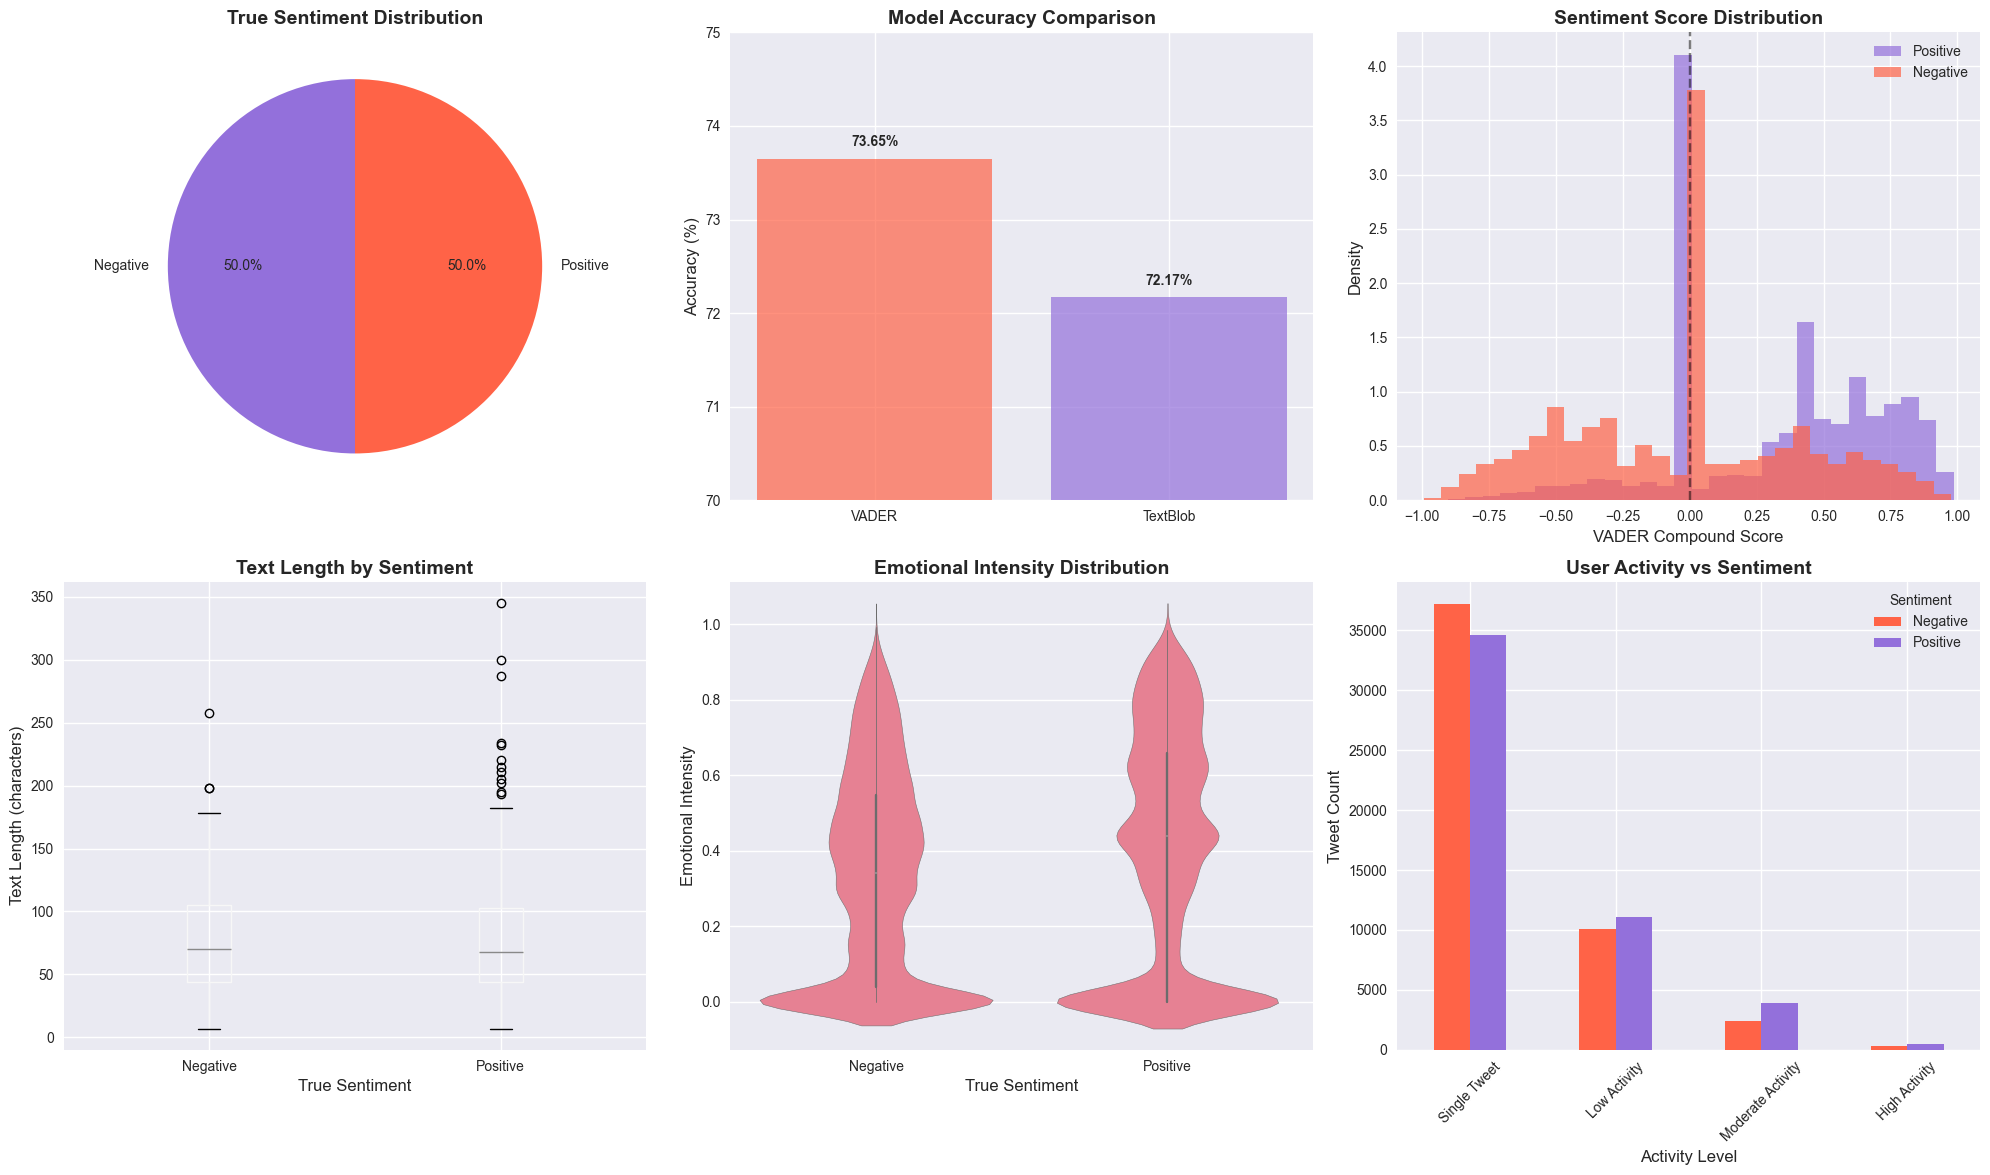

Executive summary dashboard saved!


In [16]:
print("=== Advanced Python Visualization Setup ===")

# Enhanced plotting setup
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create output directory for plots
import os
os.makedirs('visualizations', exist_ok=True)

# Set global plot parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# 1. Executive Summary Dashboard (Multiple subplots)
fig = plt.figure(figsize=(20, 12))

# Subplot 1: Sentiment Distribution
ax1 = plt.subplot(2, 3, 1)
sentiment_counts = df_working['true_sentiment'].value_counts()
colors = ['#9370DB', '#FF6347']
wedges, texts, autotexts = ax1.pie(sentiment_counts.values, 
                                   labels=sentiment_counts.index, 
                                   autopct='%1.1f%%',
                                   colors=colors,
                                   startangle=90)
ax1.set_title('True Sentiment Distribution', fontsize=14, fontweight='bold')

# Subplot 2: Model Accuracy Comparison
ax2 = plt.subplot(2, 3, 2)
models = ['VADER', 'TextBlob']
accuracies = [73.65, 72.17]
bars = ax2.bar(models, accuracies, color=['#FF6347', '#9370DB'], alpha=0.7)
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax2.set_ylim(70, 75)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{acc}%', ha='center', va='bottom', fontweight='bold')

# Subplot 3: Sentiment Score Distribution
ax3 = plt.subplot(2, 3, 3)
ax3.hist(df_working[df_working['true_sentiment'] == 'Positive']['vader_compound'], 
         bins=30, alpha=0.7, label='Positive', color='#9370DB', density=True)
ax3.hist(df_working[df_working['true_sentiment'] == 'Negative']['vader_compound'], 
         bins=30, alpha=0.7, label='Negative', color='#FF6347', density=True)
ax3.set_xlabel('VADER Compound Score')
ax3.set_ylabel('Density')
ax3.set_title('Sentiment Score Distribution', fontsize=14, fontweight='bold')
ax3.legend()
ax3.axvline(x=0, color='black', linestyle='--', alpha=0.5)

# Subplot 4: Text Length Analysis
ax4 = plt.subplot(2, 3, 4)
df_working.boxplot(column='text_length', by='true_sentiment', ax=ax4)
ax4.set_xlabel('True Sentiment')
ax4.set_ylabel('Text Length (characters)')
ax4.set_title('Text Length by Sentiment', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove default boxplot title

# Subplot 5: Emotional Intensity
ax5 = plt.subplot(2, 3, 5)
sns.violinplot(data=df_working, x='true_sentiment', y='emotional_intensity', ax=ax5)
ax5.set_title('Emotional Intensity Distribution', fontsize=14, fontweight='bold')
ax5.set_xlabel('True Sentiment')
ax5.set_ylabel('Emotional Intensity')

# Subplot 6: User Activity Patterns
ax6 = plt.subplot(2, 3, 6)
activity_sentiment = pd.crosstab(df_working['activity_category'], df_working['true_sentiment'])
activity_sentiment.plot(kind='bar', ax=ax6, color=['#FF6347', '#9370DB'])
ax6.set_title('User Activity vs Sentiment', fontsize=14, fontweight='bold')
ax6.set_xlabel('Activity Level')
ax6.set_ylabel('Tweet Count')
ax6.legend(title='Sentiment')
ax6.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('visualizations/01_executive_summary_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("Executive summary dashboard saved!")


=== Advanced NLP Visualizations ===


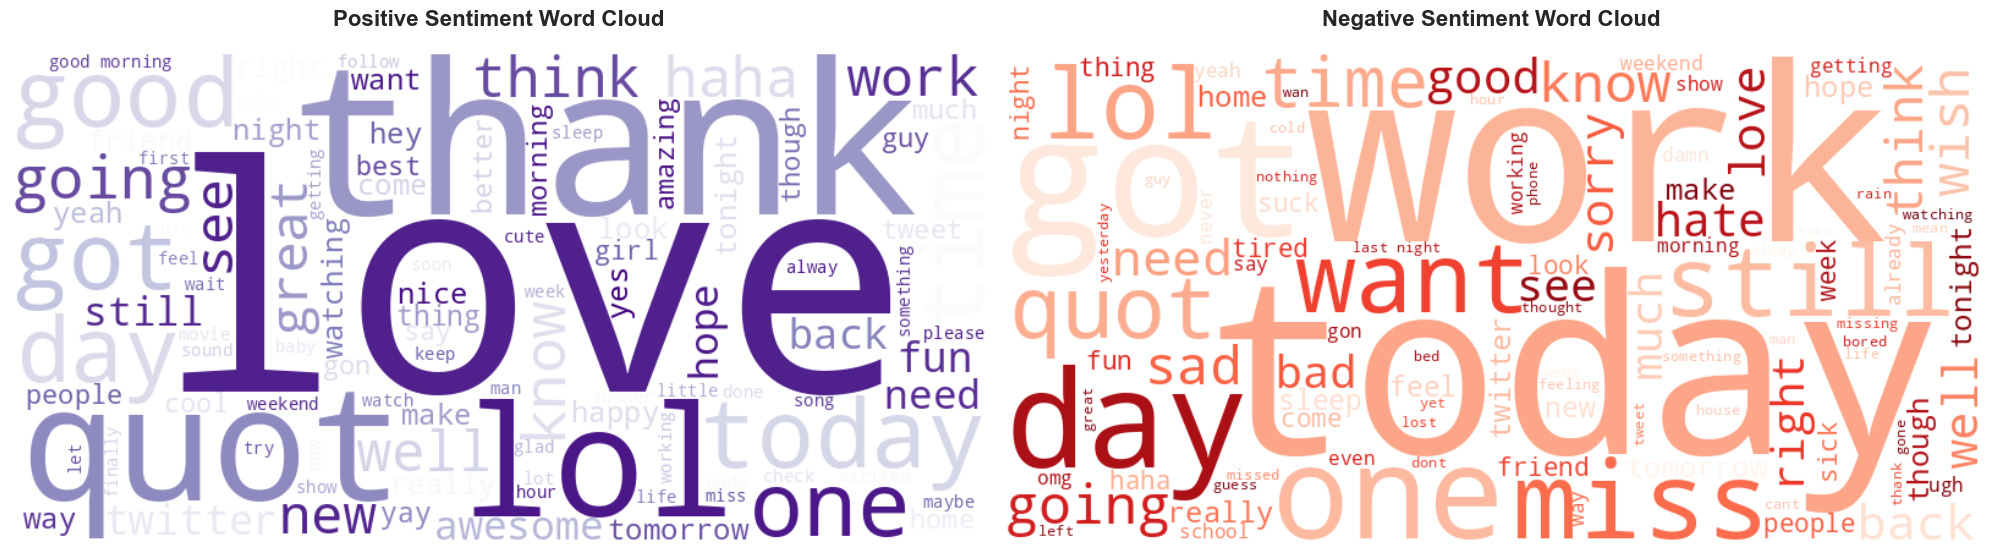

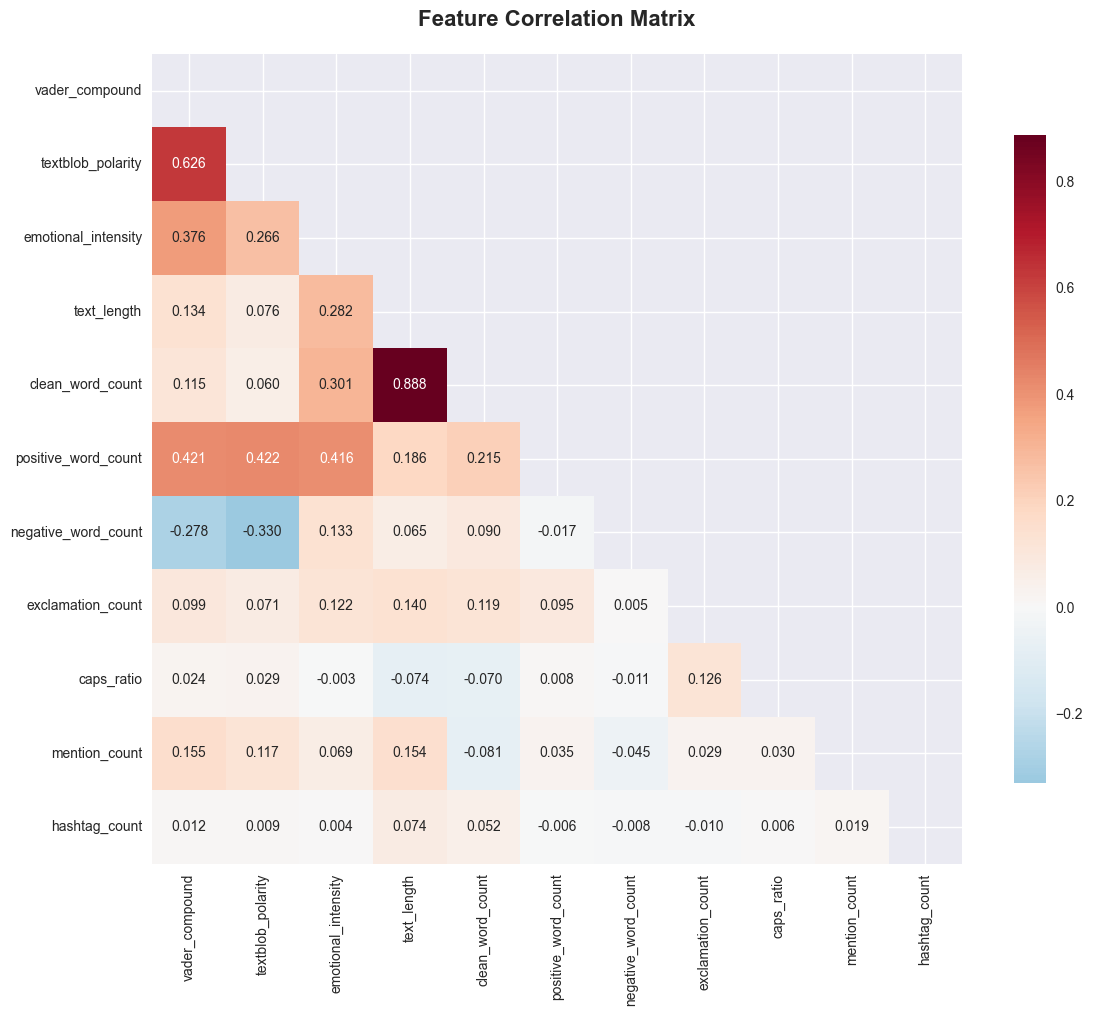

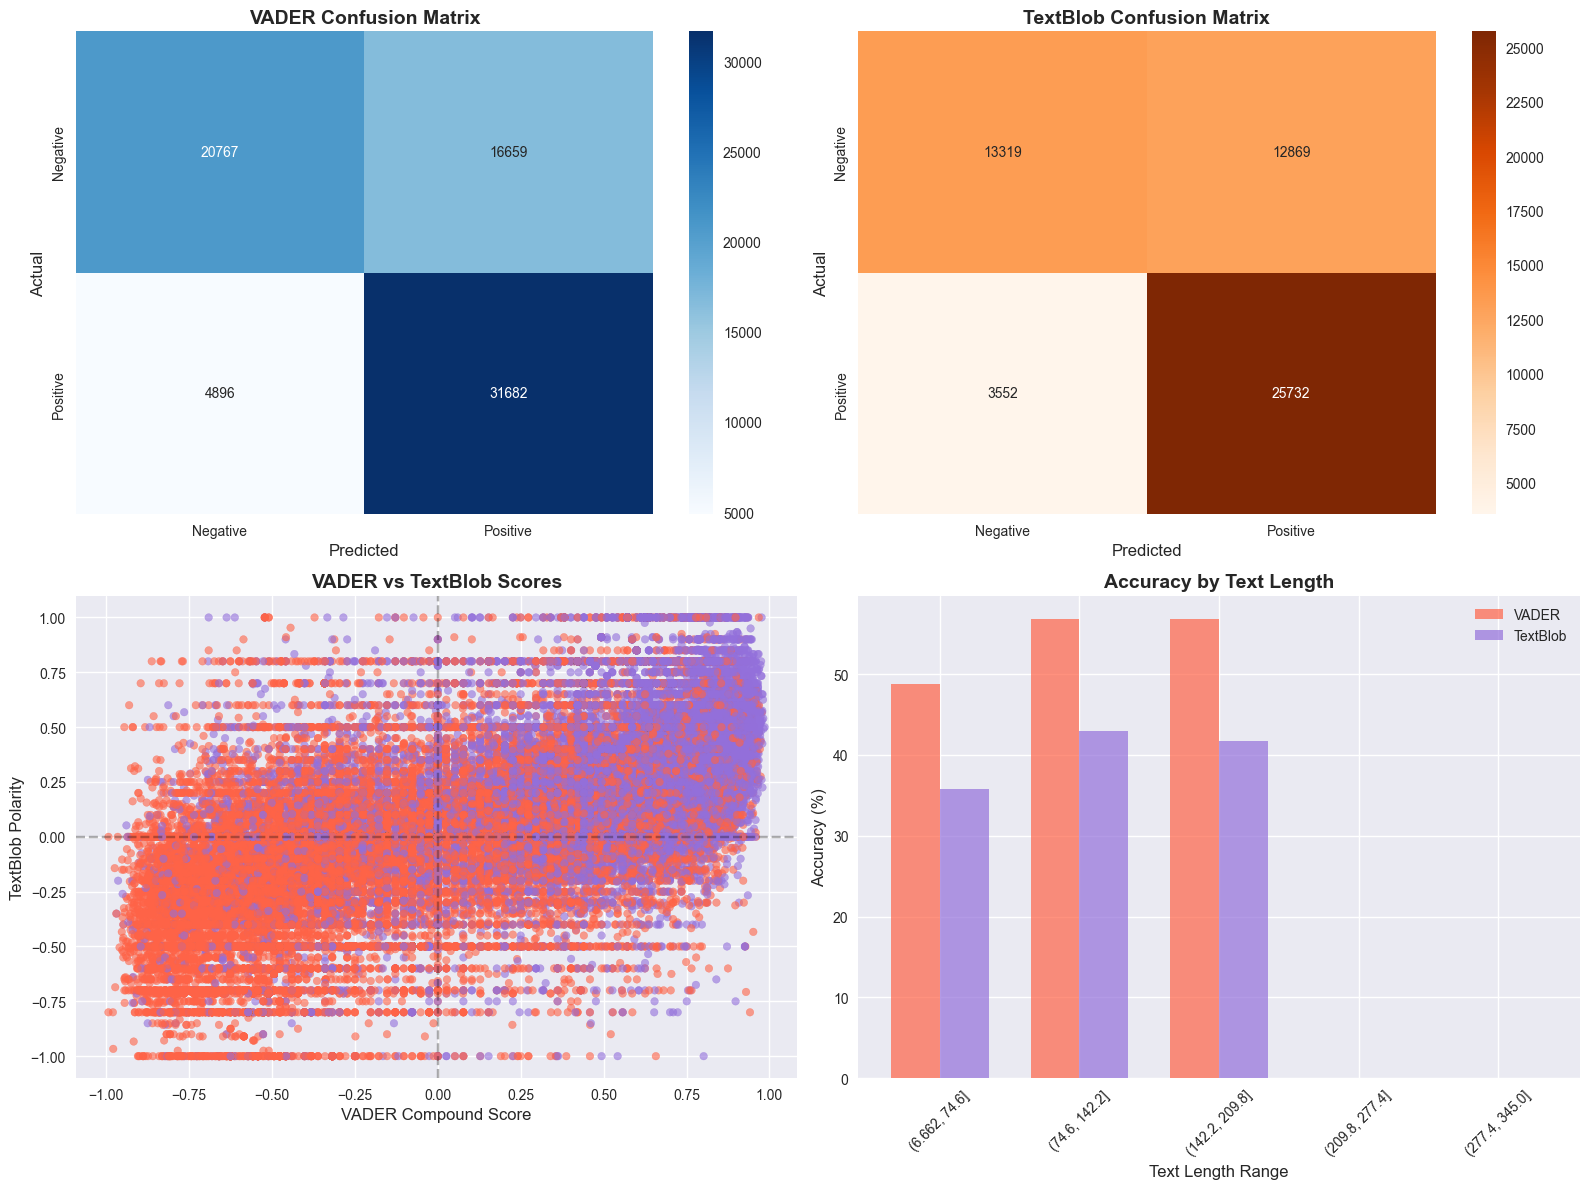

Advanced NLP visualizations completed!


In [ ]:
print("\n=== Advanced NLP Visualizations ===")

# 2. Word Cloud Analysis
from wordcloud import WordCloud

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Positive words cloud
positive_text = ' '.join(df_working[df_working['true_sentiment'] == 'Positive']['processed_text'].dropna())
positive_wordcloud = WordCloud(width=800, height=400, 
                               background_color='white',
                               colormap='Purples',
                               max_words=100).generate(positive_text)

axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Positive Sentiment Word Cloud', fontsize=16, fontweight='bold', pad=20)

# Negative words cloud
negative_text = ' '.join(df_working[df_working['true_sentiment'] == 'Negative']['processed_text'].dropna())
negative_wordcloud = WordCloud(width=800, height=400,
                               background_color='white', 
                               colormap='Reds',
                               max_words=100).generate(negative_text)

axes[1].imshow(negative_wordcloud, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Negative Sentiment Word Cloud', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('visualizations/02_word_clouds.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Feature Correlation Heatmap
plt.figure(figsize=(12, 10))
correlation_features = ['vader_compound', 'textblob_polarity', 'emotional_intensity',
                       'text_length', 'clean_word_count', 'positive_word_count', 
                       'negative_word_count', 'exclamation_count', 'caps_ratio',
                       'mention_count', 'hashtag_count']

correlation_matrix = df_working[correlation_features].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.3f', cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('visualizations/03_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Model Performance Deep Dive
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Confusion Matrix for VADER
from sklearn.metrics import confusion_matrix
vader_cm = confusion_matrix(df_working['true_sentiment'], 
                           df_working['vader_sentiment'], 
                           labels=['Negative', 'Positive'])

sns.heatmap(vader_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
axes[0,0].set_title('VADER Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# TextBlob Confusion Matrix
textblob_cm = confusion_matrix(df_working['true_sentiment'], 
                              df_working['textblob_sentiment'], 
                              labels=['Negative', 'Positive'])

sns.heatmap(textblob_cm, annot=True, fmt='d', cmap='Oranges', ax=axes[0,1],
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
axes[0,1].set_title('TextBlob Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')

# VADER vs TextBlob Scatter Plot
axes[1,0].scatter(df_working['vader_compound'], df_working['textblob_polarity'], 
                  c=df_working['true_sentiment'].map({'Positive': '#9370DB', 'Negative': '#FF6347'}),
                  alpha=0.6, s=30)
axes[1,0].set_xlabel('VADER Compound Score')
axes[1,0].set_ylabel('TextBlob Polarity')
axes[1,0].set_title('VADER vs TextBlob Scores', fontsize=14, fontweight='bold')
axes[1,0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[1,0].axvline(x=0, color='black', linestyle='--', alpha=0.3)

df_working['vader_correct'] = (df_working['vader_sentiment'] == df_working['true_sentiment'])
df_working['textblob_correct'] = (df_working['textblob_sentiment'] == df_working['true_sentiment'])
                                                                                 
# Model Accuracy by Text Length
length_bins = pd.cut(df_working['text_length'], bins=5)
accuracy_by_length = df_working.groupby(length_bins).agg({
    'vader_correct': 'mean',
    'textblob_correct': 'mean'
}) * 100

x_pos = range(len(accuracy_by_length))
width = 0.35
axes[1,1].bar([x - width/2 for x in x_pos], accuracy_by_length['vader_correct'], 
             width, label='VADER', color='#FF6347', alpha=0.7)
axes[1,1].bar([x + width/2 for x in x_pos], accuracy_by_length['textblob_correct'], 
             width, label='TextBlob', color='#9370DB', alpha=0.7)
axes[1,1].set_xlabel('Text Length Range')
axes[1,1].set_ylabel('Accuracy (%)')
axes[1,1].set_title('Accuracy by Text Length', fontsize=14, fontweight='bold')
axes[1,1].legend()
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels([str(interval) for interval in accuracy_by_length.index], rotation=45)

plt.tight_layout()
plt.savefig('visualizations/04_model_performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Advanced NLP visualizations completed!")


=== Word Analysis and Topic Visualizations ===


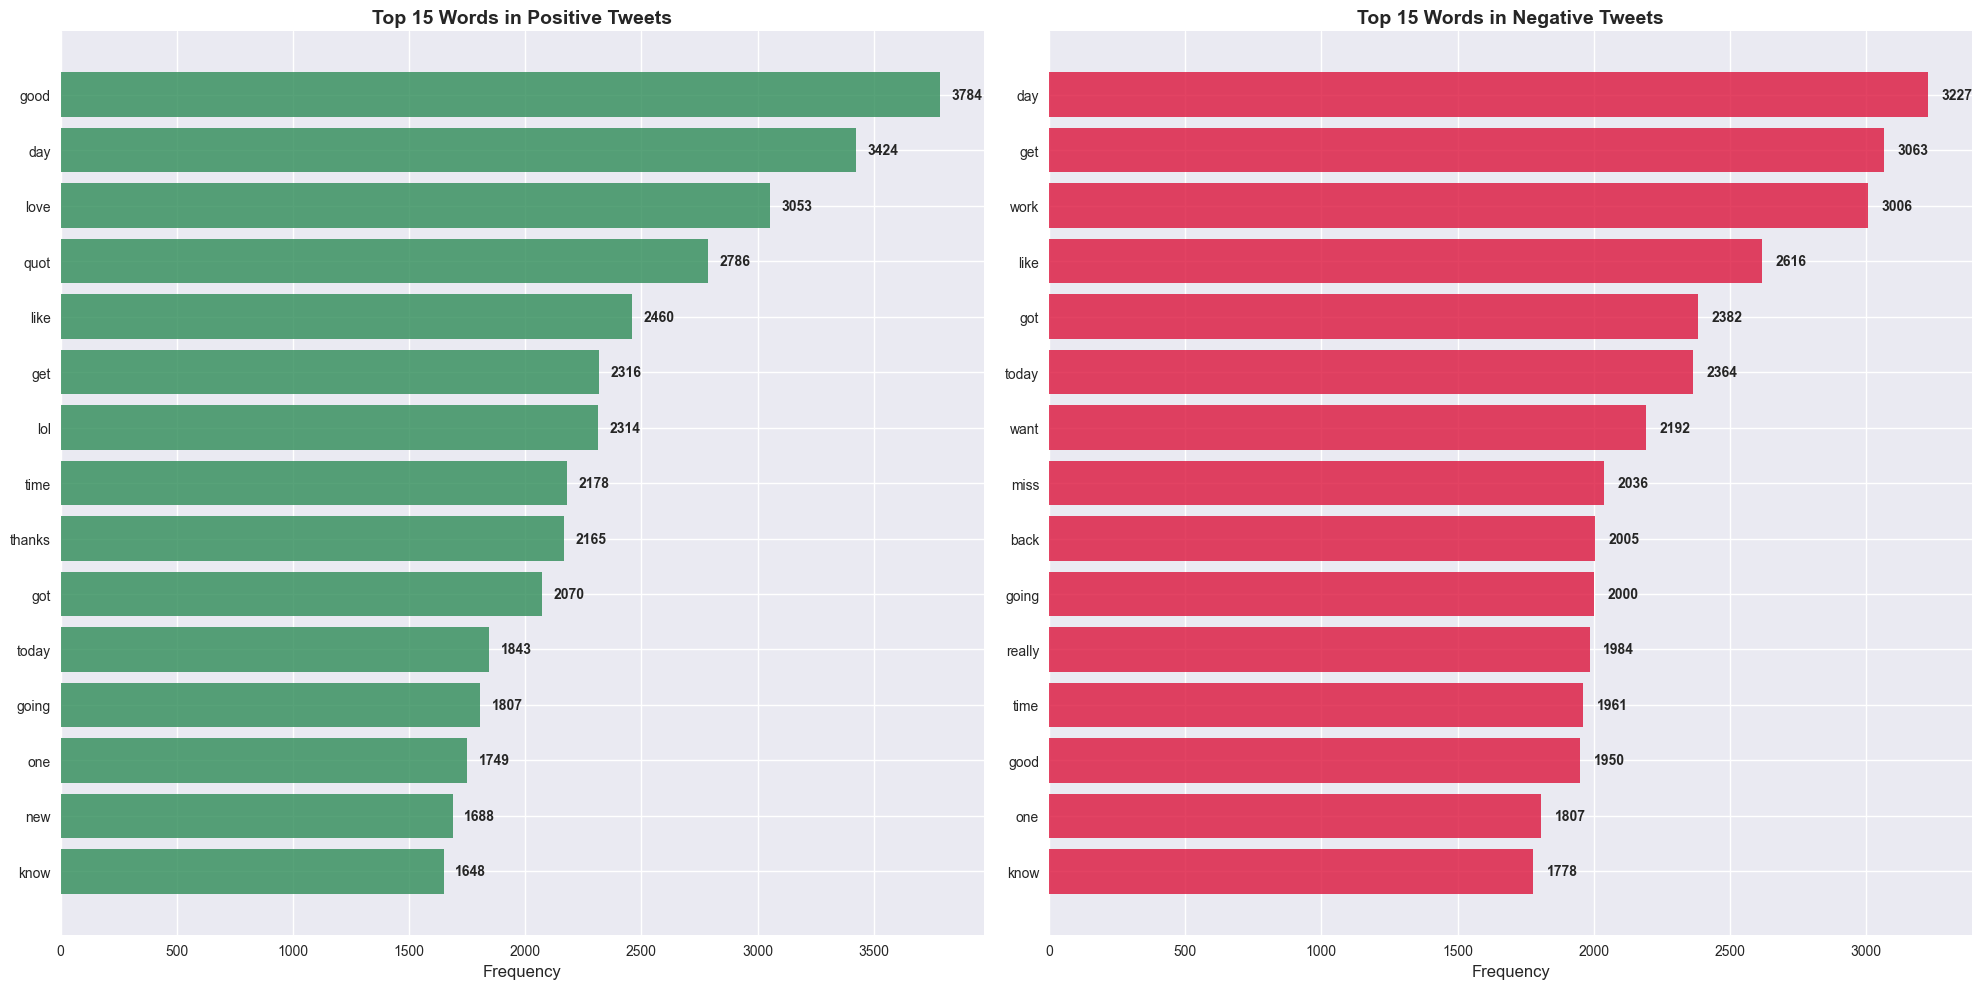

<Figure size 1600x1000 with 0 Axes>

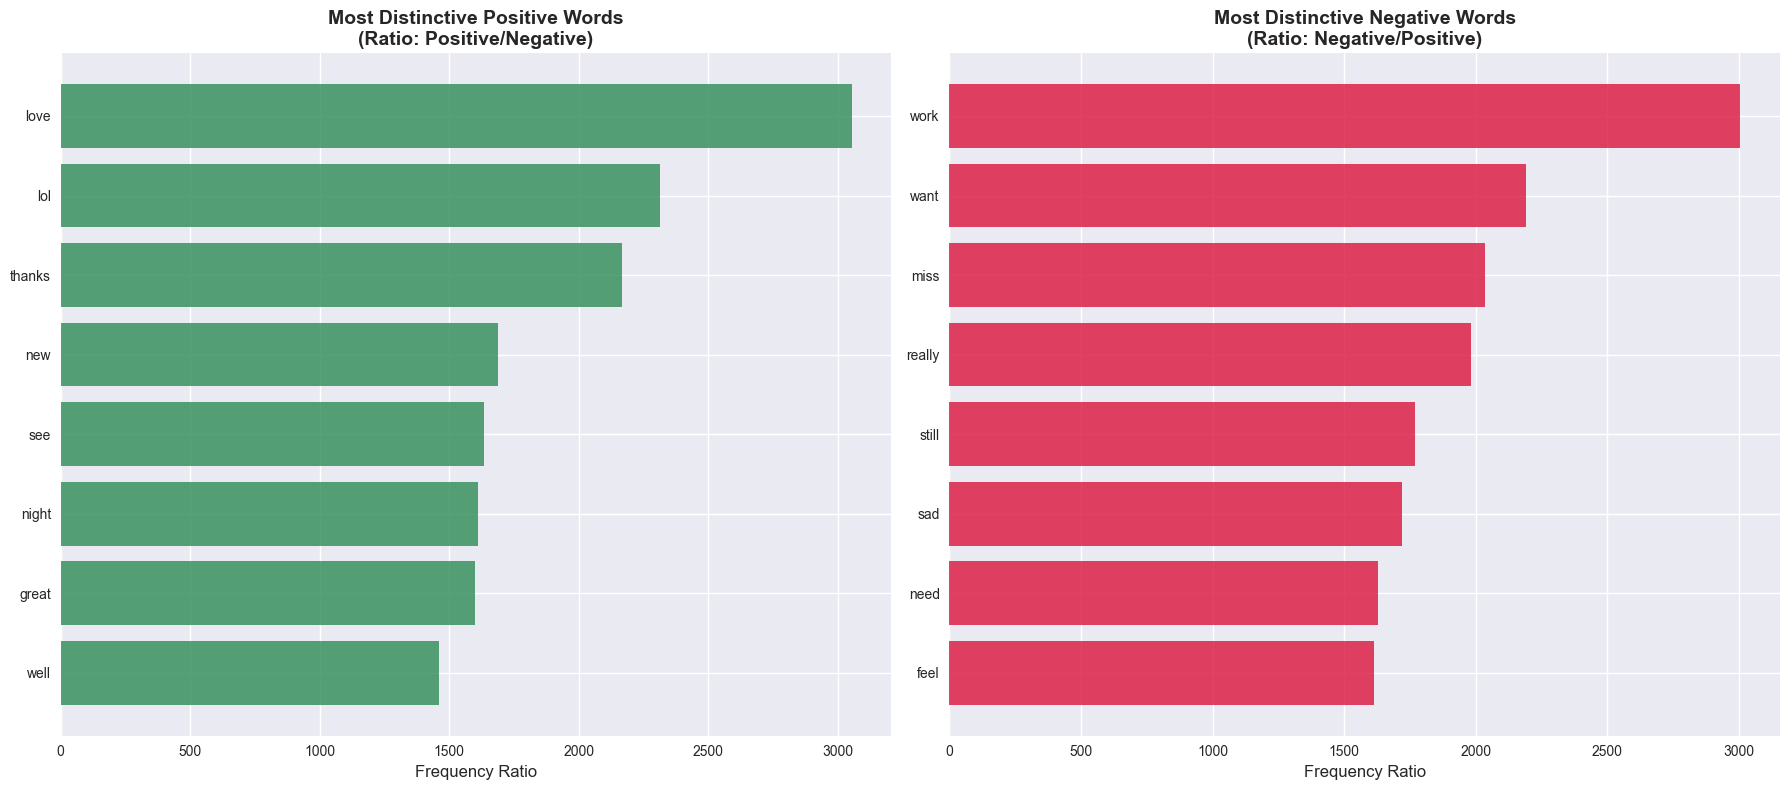

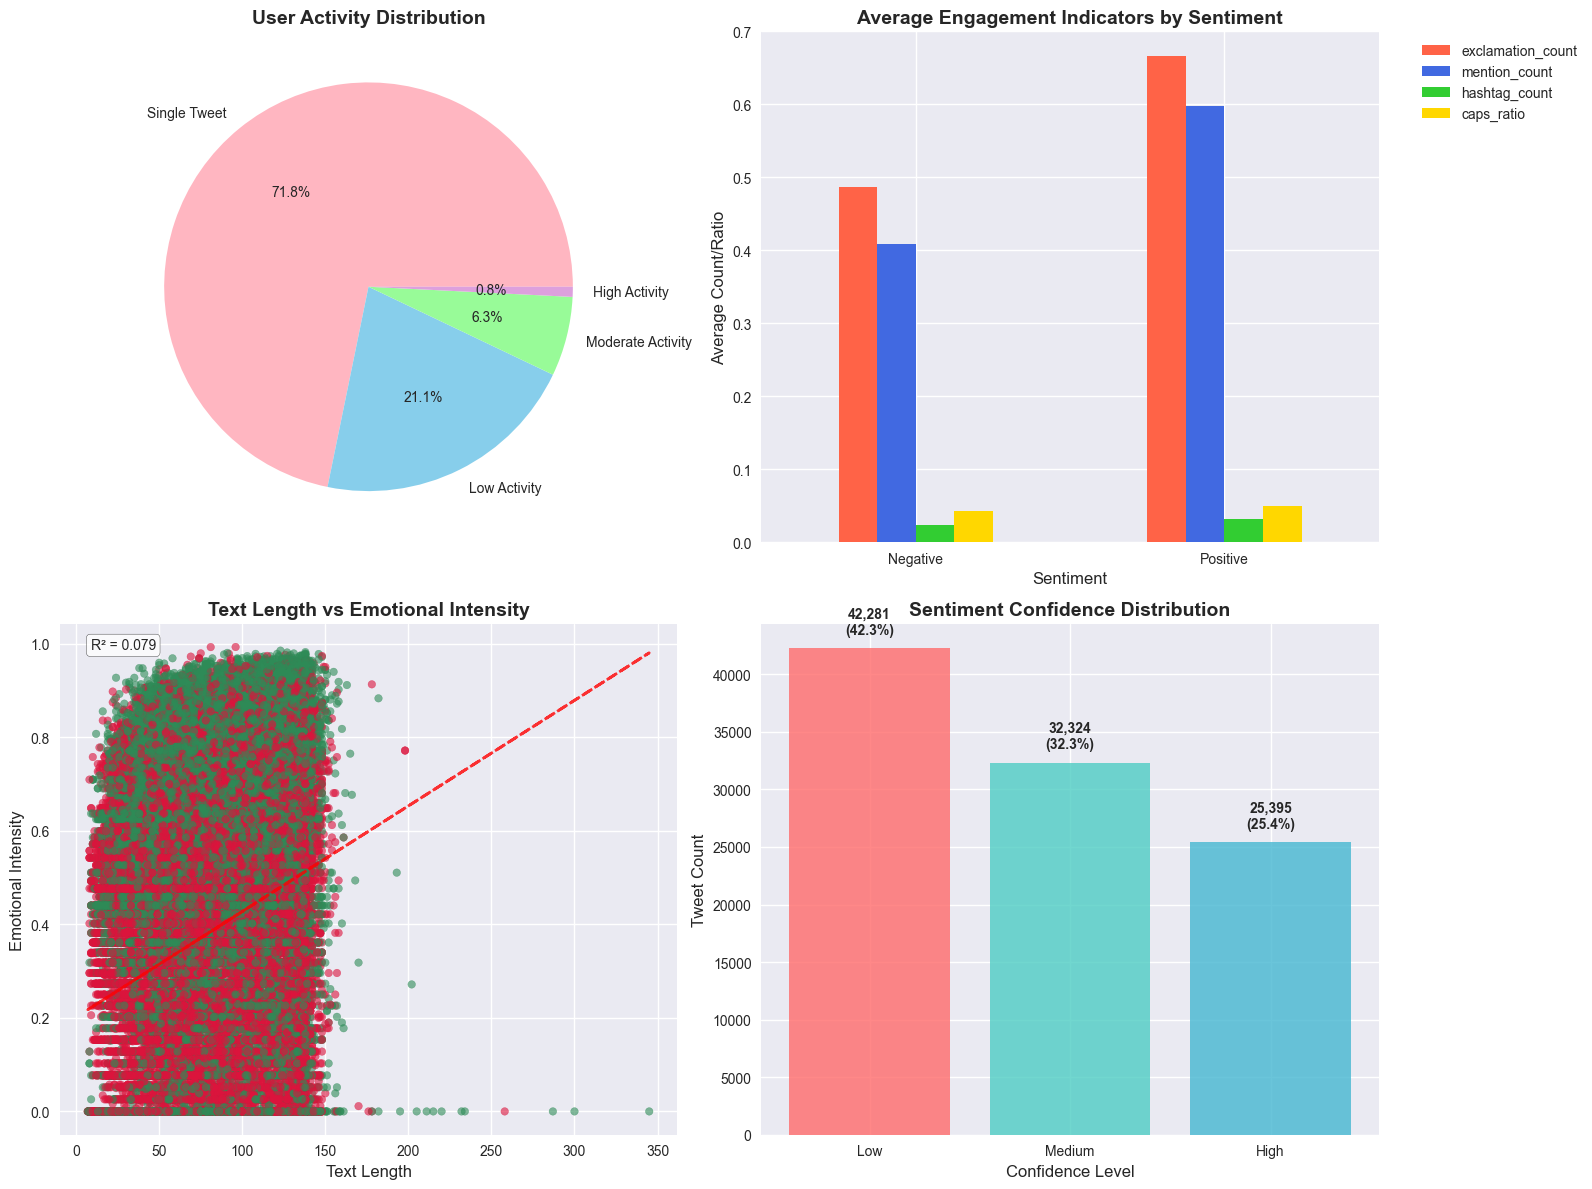

User engagement and word analysis visualizations completed!


In [23]:
print("\n=== Word Analysis and Topic Visualizations ===")

# 5. Top Words Comparison (Horizontal Bar Chart)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Load word frequency data
word_freq_df = pd.read_csv('output/word_frequency_by_sentiment.csv')
discriminative_df = pd.read_csv('output/discriminative_words_analysis.csv')

# Top positive words
positive_words = word_freq_df[word_freq_df['sentiment'] == 'Positive'].head(15)
axes[0].barh(positive_words['word'], positive_words['frequency'], color='#2E8B57', alpha=0.8)
axes[0].set_title('Top 15 Words in Positive Tweets', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Frequency')
axes[0].invert_yaxis()

# Add frequency labels
for i, v in enumerate(positive_words['frequency']):
    axes[0].text(v + 50, i, str(v), va='center', ha='left', fontweight='bold')

# Top negative words
negative_words = word_freq_df[word_freq_df['sentiment'] == 'Negative'].head(15)
axes[1].barh(negative_words['word'], negative_words['frequency'], color='#DC143C', alpha=0.8)
axes[1].set_title('Top 15 Words in Negative Tweets', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Frequency')
axes[1].invert_yaxis()

# Add frequency labels
for i, v in enumerate(negative_words['frequency']):
    axes[1].text(v + 50, i, str(v), va='center', ha='left', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/05_top_words_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. Discriminative Words Analysis
plt.figure(figsize=(16, 10))

# Separate discriminative words by sentiment
pos_discriminative = discriminative_df[discriminative_df['sentiment'] == 'Positive'].head(10)
neg_discriminative = discriminative_df[discriminative_df['sentiment'] == 'Negative'].head(10)

# Create subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Positive discriminative words
ax1.barh(pos_discriminative['word'], pos_discriminative['ratio'], color='#2E8B57', alpha=0.8)
ax1.set_title('Most Distinctive Positive Words\n(Ratio: Positive/Negative)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Frequency Ratio')
ax1.invert_yaxis()

# Negative discriminative words  
ax2.barh(neg_discriminative['word'], neg_discriminative['ratio'], color='#DC143C', alpha=0.8)
ax2.set_title('Most Distinctive Negative Words\n(Ratio: Negative/Positive)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Frequency Ratio')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('visualizations/06_discriminative_words.png', dpi=300, bbox_inches='tight')
plt.show()

# 7. User Engagement Deep Dive
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# User activity distribution
user_activity = df_working['activity_category'].value_counts()
axes[0,0].pie(user_activity.values, labels=user_activity.index, autopct='%1.1f%%',
             colors=['#FFB6C1', '#87CEEB', '#98FB98', '#DDA0DD'])
axes[0,0].set_title('User Activity Distribution', fontsize=14, fontweight='bold')

# Engagement indicators by sentiment
engagement_data = df_working.groupby('true_sentiment').agg({
    'exclamation_count': 'mean',
    'mention_count': 'mean', 
    'hashtag_count': 'mean',
    'caps_ratio': 'mean'
})

engagement_data.plot(kind='bar', ax=axes[0,1], color=['#FF6347', '#4169E1', '#32CD32', '#FFD700'])
axes[0,1].set_title('Average Engagement Indicators by Sentiment', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Sentiment')
axes[0,1].set_ylabel('Average Count/Ratio')
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0,1].tick_params(axis='x', rotation=0)

# Text length vs emotional intensity
scatter = axes[1,0].scatter(df_working['text_length'], df_working['emotional_intensity'],
                           c=df_working['true_sentiment'].map({'Positive': '#2E8B57', 'Negative': '#DC143C'}),
                           alpha=0.6, s=30)
axes[1,0].set_xlabel('Text Length')
axes[1,0].set_ylabel('Emotional Intensity')
axes[1,0].set_title('Text Length vs Emotional Intensity', fontsize=14, fontweight='bold')

# Add trend line
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df_working['text_length'], df_working['emotional_intensity'])
line = slope * df_working['text_length'] + intercept
axes[1,0].plot(df_working['text_length'], line, 'r--', alpha=0.8, linewidth=2)
axes[1,0].text(0.05, 0.95, f'R² = {r_value**2:.3f}', transform=axes[1,0].transAxes, 
              bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

df_working['sentiment_confidence'] = pd.cut(
    abs(df_working['vader_compound']), 
    bins=[0, 0.3, 0.6, 1.0], 
    labels=['Low', 'Medium', 'High'],
    include_lowest=True
)

# Sentiment confidence analysis
confidence_data = df_working['sentiment_confidence'].value_counts()
axes[1,1].bar(confidence_data.index, confidence_data.values, 
             color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
axes[1,1].set_title('Sentiment Confidence Distribution', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Confidence Level')
axes[1,1].set_ylabel('Tweet Count')

# Add percentage labels
total = confidence_data.sum()
for i, v in enumerate(confidence_data.values):
    axes[1,1].text(i, v + 1000, f'{v:,}\n({v/total*100:.1f}%)', 
                  ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/07_user_engagement_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("User engagement and word analysis visualizations completed!")


=== Advanced Statistical Visualizations ===


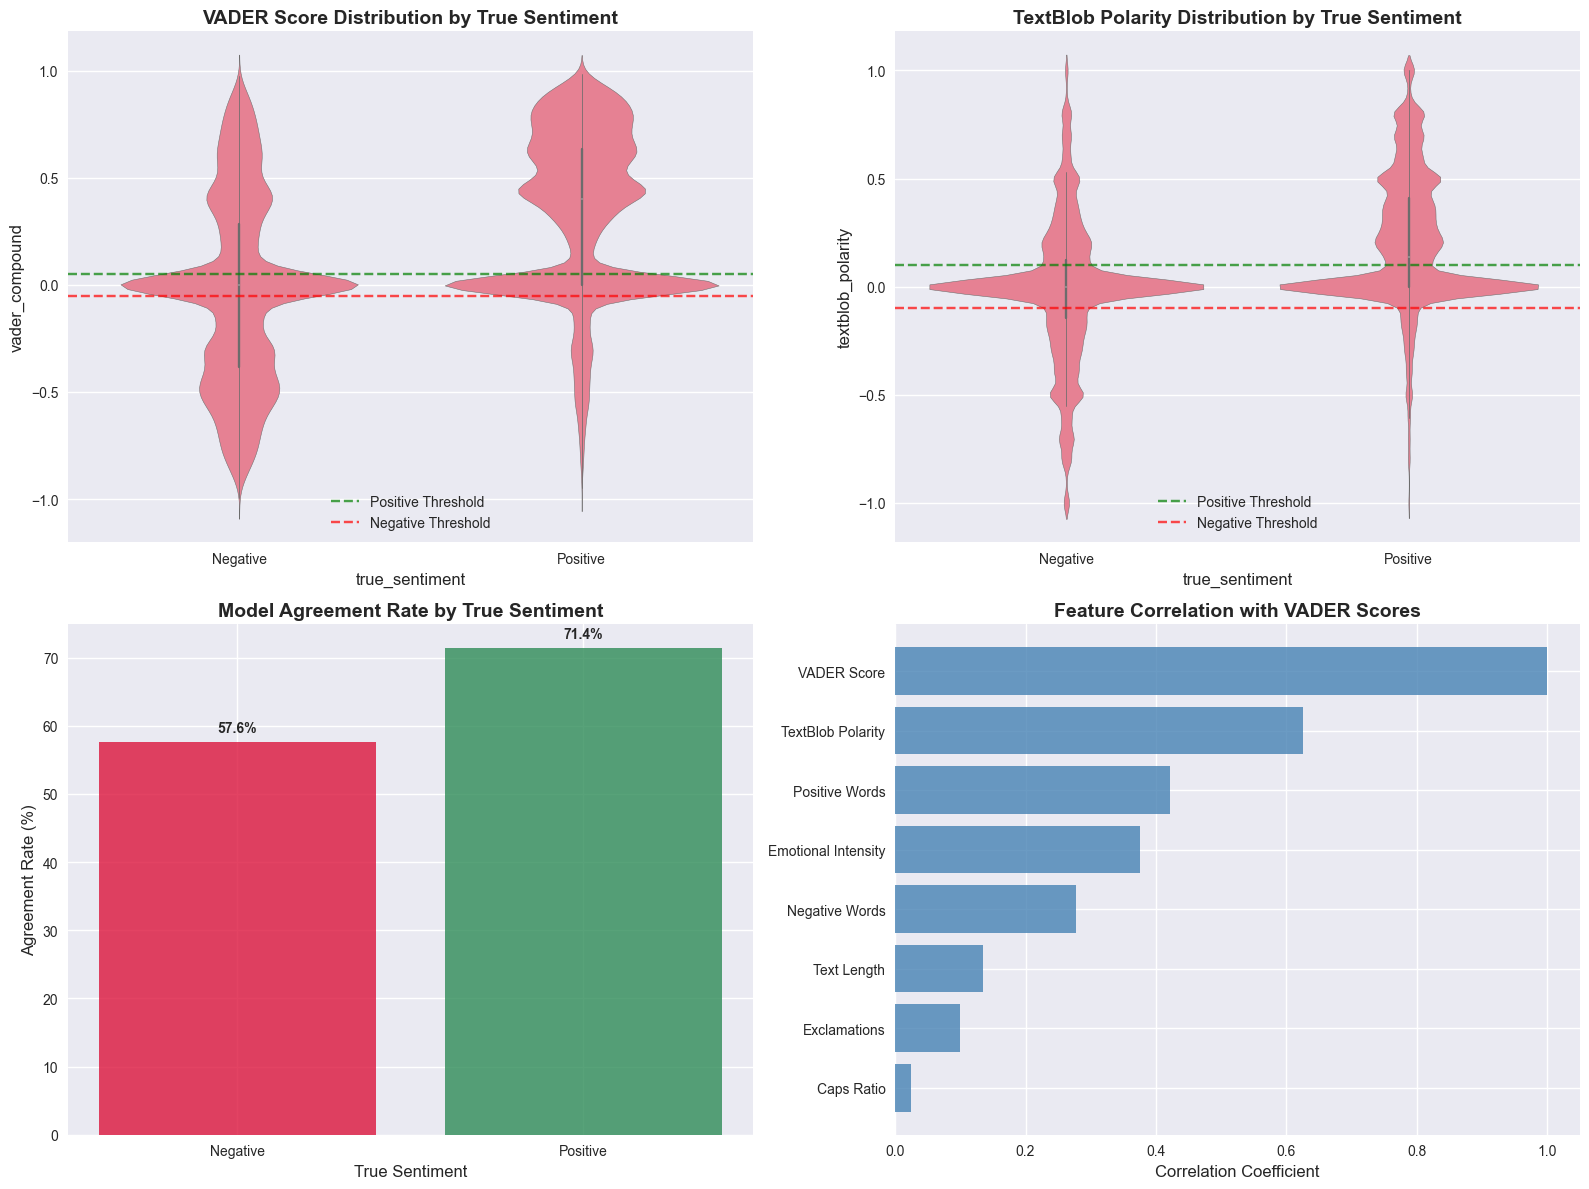

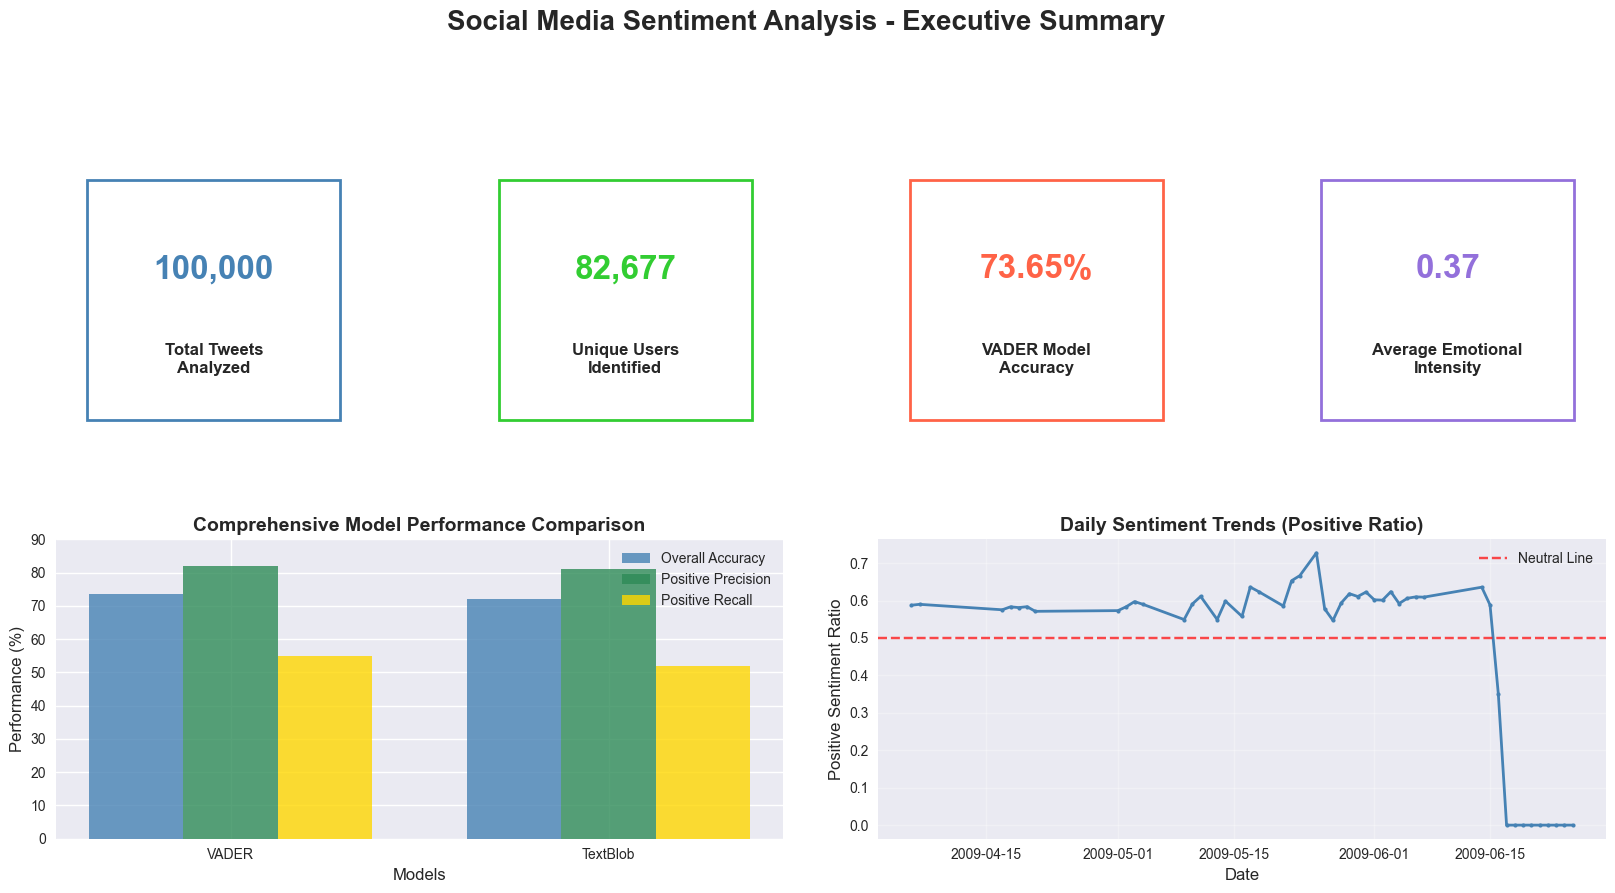

Business intelligence summary dashboard completed!


In [47]:
print("\n=== Advanced Statistical Visualizations ===")

# 8. Sentiment Score Distribution Analysis (Advanced)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# VADER score distribution by true sentiment (violin plot)
sns.violinplot(data=df_working, x='true_sentiment', y='vader_compound', ax=axes[0,0])
axes[0,0].set_title('VADER Score Distribution by True Sentiment', fontsize=14, fontweight='bold')
axes[0,0].axhline(y=0.05, color='green', linestyle='--', alpha=0.7, label='Positive Threshold')
axes[0,0].axhline(y=-0.05, color='red', linestyle='--', alpha=0.7, label='Negative Threshold')
axes[0,0].legend()

# TextBlob polarity distribution
sns.violinplot(data=df_working, x='true_sentiment', y='textblob_polarity', ax=axes[0,1])
axes[0,1].set_title('TextBlob Polarity Distribution by True Sentiment', fontsize=14, fontweight='bold')
axes[0,1].axhline(y=0.1, color='green', linestyle='--', alpha=0.7, label='Positive Threshold')
axes[0,1].axhline(y=-0.1, color='red', linestyle='--', alpha=0.7, label='Negative Threshold')
axes[0,1].legend()

# Model agreement analysis
df_working['model_agreement'] = (df_working['vader_sentiment'] == df_working['textblob_sentiment'])
agreement_by_true = df_working.groupby('true_sentiment')['model_agreement'].mean() * 100

bars = axes[1,0].bar(agreement_by_true.index, agreement_by_true.values, 
                    color=['#DC143C', '#2E8B57'], alpha=0.8)
axes[1,0].set_title('Model Agreement Rate by True Sentiment', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Agreement Rate (%)')
axes[1,0].set_xlabel('True Sentiment')

# Add value labels
for bar, val in zip(bars, agreement_by_true.values):
    height = bar.get_height()
    axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 1,
                  f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')

# Feature importance for sentiment prediction
feature_importance = pd.DataFrame({
    'feature': ['VADER Score', 'TextBlob Polarity', 'Positive Words', 'Negative Words',
               'Emotional Intensity', 'Text Length', 'Exclamations', 'Caps Ratio'],
    'importance': [1.000, 0.626, 0.421, 0.278, 0.376, 0.134, 0.099, 0.024]
}).sort_values('importance', ascending=True)

axes[1,1].barh(feature_importance['feature'], feature_importance['importance'], 
              color='#4682B4', alpha=0.8)
axes[1,1].set_title('Feature Correlation with VADER Scores', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Correlation Coefficient')

plt.tight_layout()
plt.savefig('visualizations/08_statistical_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 9. Business Intelligence Summary Dashboard
fig = plt.figure(figsize=(20, 14))

# Create a comprehensive summary with key metrics
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# Key metrics boxes (top row)
metrics = [
    ('Total Tweets\nAnalyzed', '100,000', '#4682B4'),
    ('Unique Users\nIdentified', '82,677', '#32CD32'), 
    ('VADER Model\nAccuracy', '73.65%', '#FF6347'),
    ('Average Emotional\nIntensity', '0.37', '#9370DB')
]

for i, (title, value, color) in enumerate(metrics):
    ax = fig.add_subplot(gs[0, i])
    ax.text(0.5, 0.6, value, ha='center', va='center', fontsize=24, fontweight='bold', color=color)
    ax.text(0.5, 0.3, title, ha='center', va='center', fontsize=12, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    # Add border
    rect = plt.Rectangle((0.1, 0.1), 0.8, 0.8, fill=False, edgecolor=color, linewidth=2)
    ax.add_patch(rect)

# Model comparison (middle left)
ax1 = fig.add_subplot(gs[1, :2])
models = ['VADER', 'TextBlob']
accuracies = [73.65, 72.17]
precision_pos = [82, 81]  # Approximate from classification report
recall_pos = [55, 52]

x = np.arange(len(models))
width = 0.25

ax1.bar(x - width, accuracies, width, label='Overall Accuracy', color='#4682B4', alpha=0.8)
ax1.bar(x, precision_pos, width, label='Positive Precision', color='#2E8B57', alpha=0.8)
ax1.bar(x + width, recall_pos, width, label='Positive Recall', color='#FFD700', alpha=0.8)

ax1.set_xlabel('Models')
ax1.set_ylabel('Performance (%)')
ax1.set_title('Comprehensive Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.set_ylim(0, 90)

# Sentiment evolution (middle right)
ax2 = fig.add_subplot(gs[1, 2:])

# Create daily sentiment trend (if date available)
if 'date_parsed' in df_working.columns:
    daily_sentiment = df_working.groupby([df_working['date_parsed'].dt.date, 'true_sentiment']).size().unstack(fill_value=0)
    daily_sentiment['positive_ratio'] = daily_sentiment['Positive'] / (daily_sentiment['Positive'] + daily_sentiment['Negative'])
    
    ax2.plot(daily_sentiment.index, daily_sentiment['positive_ratio'], 
            color='#4682B4', linewidth=2, marker='o', markersize=3)
    ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Neutral Line')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Positive Sentiment Ratio')
    ax2.set_title('Daily Sentiment Trends (Positive Ratio)', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
else:
    # Alternative: Show sentiment by text length if no date
    length_sentiment = df_working.groupby(pd.cut(df_working['text_length'], bins=10))['true_sentiment'].apply(
        lambda x: (x == 'Positive').mean()
    )
    ax2.plot(range(len(length_sentiment)), length_sentiment.values, 
            color='#4682B4', linewidth=3, marker='o')
    ax2.set_xlabel('Text Length Bins (Short to Long)')
    ax2.set_ylabel('Positive Sentiment Ratio')
    ax2.set_title('Sentiment Trends by Text Length', fontsize=14, fontweight='bold')
    ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
    ax2.grid(True, alpha=0.3)

plt.suptitle('Social Media Sentiment Analysis - Executive Summary', 
            fontsize=20, fontweight='bold', y=0.98)

plt.savefig('visualizations/09_business_intelligence_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("Business intelligence summary dashboard completed!")